In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from lens import profile
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from numpy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift

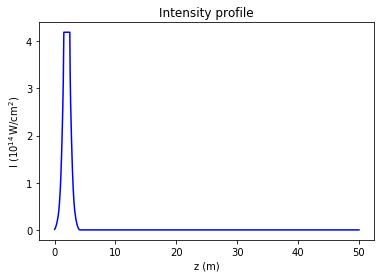

0.0


In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

plt.plot(z/1e6, I, 'b-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.show()
print(I[N-1])

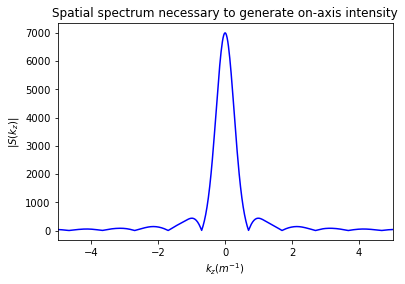

In [3]:
# First what is the spatial spectrum with 0 phase on the entire output
lam = 0.8
k = 2*np.pi/lam

S = fftshift(fft(I))
kz = fftshift(fftfreq(np.size(z), z[1]-z[0]))
#kr = np.sqrt(k**2 - kz**2)
plt.plot(kz*1e6, abs(S), 'b-')
plt.xlabel(r'$k_z (m^{-1})$')
plt.ylabel(r'$|S(k_z)|$')
plt.title('Spatial spectrum necessary to generate on-axis intensity')
plt.xlim([-5, 5])
plt.show()
# The DC spike is due to the slow asymptotic behavior of adk model
# Requiring ~0 ionization fraction still returns some DC intensity from inverse ADK

k  :  7.853981633974483 um^-1
kz0:  7.85397754329 um^-1
k - kz0:  4.0906813723e-06 um^-1


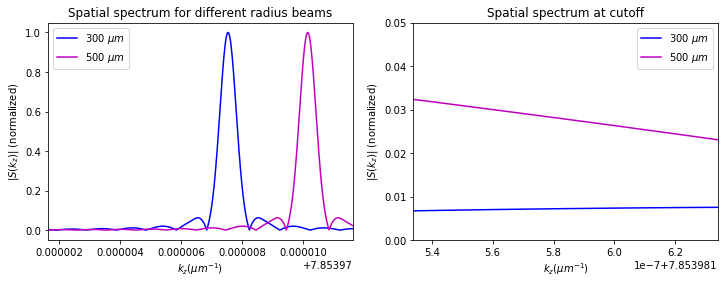

In [4]:
# The distribution is the smae as the unshifted case but centered at kz0
# Rb is the radius of the main lobe of the bessel function
Rb = 0.3e3
kr0 = 2.4048/Rb
kz0 = np.sqrt(k**2-kr0**2)
# The limitation is that our spatial spectrum must fit below k
print('k  : ', k, 'um^-1')
print('kz0: ', kz0, 'um^-1')
print('k - kz0: ', k-kz0, 'um^-1')

# Comparison for a 1mm radius beam
Rbmm = 0.5e3
kr0mm = 2.4048/Rbmm
kz0mm = np.sqrt(k**2-kr0mm**2)
# For normalizing
Smax = np.amax(abs(S))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(kz+kz0, abs(S)/Smax, 'b-', kz+kz0mm, abs(S)/Smax, 'm-')
plt.xlabel(r'$k_z (\mu m^{-1})$')
plt.ylabel(r'$|S(k_z)|$ (normalized)')
plt.title('Spatial spectrum for different radius beams')
plt.xlim([k-1e-5, k])
plt.legend([r'300 $\mu m$', r'500 $\mu m$'])

plt.subplot(122)
plt.plot(kz+kz0, abs(S)/Smax, 'b-', kz+kz0mm, abs(S)/Smax, 'm-')
plt.xlabel(r'$k_z (\mu m^{-1})$')
plt.ylabel(r'$|S(k_z)|$ (normalized)')
plt.title('Spatial spectrum at cutoff')
plt.xlim([k-1e-7, k])
plt.ylim([0,0.05])
plt.legend([r'300 $\mu m$', r'500 $\mu m$'])
plt.show()
# A 300um radius beam is on the edge of what is possible
# we might be able to decrease the tails be getting rid of the corners

In [ ]:
# Attempt at using the Hankel package
from hankel import SymmetricFourierTransform
ft = SymmetricFourierTransform(ndim=1, N = N, h = 0.03)